# Bilinear Layer for Modular Addition
Based on task: Train a bilinear layer on modular arithmetic (mod 113)
Visualize interaction matrices and top eigenvector components


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1337)
np.random.seed(1337)


In [12]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Bilinear MLP Implementation


In [13]:
# Bilinear MLP for Modular Addition
# Architecture: g(x) = (Wx) ⊙ (Vx), output = P[g(x)]

class BilinearMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BilinearMLP, self).__init__()
        # Two encoder matrices W and V
        self.W = torch.nn.Linear(input_size, hidden_size, bias=False)
        self.V = torch.nn.Linear(input_size, hidden_size, bias=False)
        # Output projection P
        self.P = torch.nn.Linear(hidden_size, output_size, bias=False)

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

    def forward(self, x):
        # Bilinear layer: element-wise product of two linear projections
        w_proj = self.W(x)  # (batch, hidden)
        v_proj = self.V(x)  # (batch, hidden)
        g = w_proj * v_proj  # Element-wise product
        output = self.P(g)   # Project to output
        return output, w_proj, v_proj, g

    def get_interaction_matrix(self, output_idx):
        """
        Get the interaction matrix for a specific output dimension.
        Q = w_u ⊗ v_u^T (outer product)
        where w_u and v_u are the weights leading to output dimension u
        """
        # Get the output weights for this dimension
        p_weights = self.P.weight[output_idx]  # (hidden_size,)

        # Get W and V weights
        W_weights = self.W.weight  # (hidden_size, input_size)
        V_weights = self.V.weight  # (hidden_size, input_size)

        # Compute weighted sum of outer products
        # Q = sum_k p_k * (w_k ⊗ v_k^T)
        Q = torch.zeros(self.input_size, self.input_size, device=p_weights.device)
        for k in range(self.hidden_size):
            w_k = W_weights[k]  # (input_size,)
            v_k = V_weights[k]  # (input_size,)
            # Add outer product, weighted by output weight
            Q += p_weights[k] * torch.outer(w_k, v_k)

        # Make symmetric (as per paper)
        Q = 0.5 * (Q + Q.T)
        return Q

    def get_bilinear_tensor(self):
        """
        Get the full bilinear tensor B with shape (output_size, input_size, input_size)
        b_uij = sum_k p_uk * w_ki * v_kj
        """
        W_weights = self.W.weight  # (hidden_size, input_size)
        V_weights = self.V.weight  # (hidden_size, input_size)
        P_weights = self.P.weight  # (output_size, hidden_size)

        # Compute tensor: einsum is efficient for this
        # B[u,i,j] = sum_k P[u,k] * W[k,i] * V[k,j]
        B = torch.einsum('uk,ki,kj->uij', P_weights, W_weights, V_weights)

        # Make each slice symmetric
        B = 0.5 * (B + B.transpose(1, 2))
        return B

    def eigendecompose_output(self, output_idx, top_k=10):
        """
        Perform eigendecomposition on the interaction matrix for a specific output.
        Returns eigenvalues and eigenvectors sorted by absolute eigenvalue magnitude.
        """
        Q = self.get_interaction_matrix(output_idx)
        Q_np = Q.cpu().detach().numpy()

        # Eigendecomposition (Q is symmetric, so eigenvectors are orthogonal)
        eigenvalues, eigenvectors = np.linalg.eigh(Q_np)

        # Sort by absolute magnitude
        idx = np.argsort(np.abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        return eigenvalues[:top_k], eigenvectors[:, :top_k]

    def hosvd_decomposition(self, num_components=5):
        """
        Section 3.3: Higher-Order SVD
        Discovers the most important output directions without prior knowledge.
        Returns:
            U: Output directions (output_size, num_components)
            S: Singular values (importance of each direction)
            interaction_matrices: Interaction matrices for each direction
        """
        # Get full bilinear tensor (output_size, input_size, input_size)
        B = self.get_bilinear_tensor()
        B_np = B.cpu().detach().numpy()

        # Reshape: (output_size, input_size, input_size) → (output_size, input_size²)
        B_flat = B_np.reshape(self.output_size, -1)

        # SVD to find important output directions
        U, S, Vh = np.linalg.svd(B_flat, full_matrices=False)

        # Reconstruct interaction matrices for each discovered direction
        interaction_matrices = []
        for i in range(num_components):
            # Reshape back to (input_size, input_size)
            Q = Vh[i].reshape(self.input_size, self.input_size)
            # Symmetrize
            Q = 0.5 * (Q + Q.T)
            interaction_matrices.append(Q)

        return U[:, :num_components], S[:num_components], interaction_matrices

# Training function for bilinear model
def train_bilinear(model, train_data, train_labels, val_data, val_labels, epochs, batch_size, lr, weight_decay):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        correct_train_preds = 0
        total_train_preds = 0

        for batch in range(0, len(train_data), batch_size):
            optimizer.zero_grad()
            output, _, _, _ = model(train_data[batch:batch+batch_size])
            loss = loss_fn(output, torch.argmax(train_labels[batch:batch+batch_size], axis=1))
            running_train_loss += loss.item()

            preds = torch.argmax(output, axis=1)
            correct_train_preds += (preds == torch.argmax(train_labels[batch:batch+batch_size], axis=1)).sum().item()
            total_train_preds += len(preds)

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            output, _, _, _ = model(val_data)
            val_loss = loss_fn(output, torch.argmax(val_labels, axis=1)).item()
            val_preds = torch.argmax(output, axis=1)
            correct_val_preds = (val_preds == torch.argmax(val_labels, axis=1)).sum().item()
            total_val_preds = len(val_preds)

        avg_train_loss = running_train_loss / (len(train_data) / batch_size)
        train_acc = correct_train_preds / total_train_preds
        val_acc = correct_val_preds / total_val_preds

        train_loss_values.append(avg_train_loss)
        val_loss_values.append(val_loss)
        train_acc_values.append(train_acc)
        val_acc_values.append(val_acc)

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch} | Train loss: {avg_train_loss:.4f} | Val loss: {val_loss:.4f} | Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

    return model, train_loss_values, val_loss_values, train_acc_values, val_acc_values


## Training the Bilinear Model


In [14]:
# Prepare dataset for bilinear model training
p = 113
data_set = np.zeros((p*p, 2*p))
labels = np.zeros((p*p, p))

for number1 in range(p):
    for number2 in range(p):
        data_set[number1*p + number2][number1] = 1
        data_set[number1*p + number2][number2+p] = 1
        labels[number1*p + number2][(number1 + number2) % p] = 1

# Shuffle the dataset
shuffle = np.random.permutation(p*p)
data_set = data_set[shuffle]
labels = labels[shuffle]

# Split into train and validation
train_proportion = 0.8
train_data = data_set[:int(train_proportion*p*p)]
train_labels = labels[:int(train_proportion*p*p)]
val_data = data_set[int(train_proportion*p*p):]
val_labels = labels[int(train_proportion*p*p):]

# Convert to tensors
train_data = torch.from_numpy(train_data).float().to(device)
train_labels = torch.from_numpy(train_labels).float().to(device)
val_data = torch.from_numpy(val_data).float().to(device)
val_labels = torch.from_numpy(val_labels).float().to(device)

print(f"Dataset prepared: {len(train_data)} training samples, {len(val_data)} validation samples")

# Train bilinear model
bilinear_model = BilinearMLP(input_size=2*p, hidden_size=100, output_size=p).to(device)
num_epochs = 1000
print(f"\nTraining Bilinear MLP for {num_epochs} epochs...")

bilinear_model, train_loss, val_loss, train_acc, val_acc = train_bilinear(
    bilinear_model, train_data, train_labels, val_data, val_labels,
    epochs=num_epochs, batch_size=128, lr=0.003, weight_decay=0.5
)

print(f"\nFinal training accuracy: {train_acc[-1]:.4f}")
print(f"Final validation accuracy: {val_acc[-1]:.4f}")


Dataset prepared: 10215 training samples, 2554 validation samples

Training Bilinear MLP for 1000 epochs...
Epoch: 0 | Train loss: 4.7396 | Val loss: 4.7284 | Train acc: 0.0025 | Val acc: 0.0012
Epoch: 100 | Train loss: 0.0040 | Val loss: 0.0073 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 200 | Train loss: 0.0008 | Val loss: 0.0017 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 300 | Train loss: 0.0003 | Val loss: 0.0007 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 400 | Train loss: 0.0002 | Val loss: 0.0005 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 500 | Train loss: 0.0002 | Val loss: 0.0006 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 600 | Train loss: 0.0003 | Val loss: 0.0009 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 700 | Train loss: 0.0006 | Val loss: 0.0016 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 800 | Train loss: 0.0008 | Val loss: 0.0020 | Train acc: 1.0000 | Val acc: 1.0000
Epoch: 900 | Train loss: 0.0009 | Val loss: 0.0022 | Train acc: 1.0000 | Val acc: 1.0000
Epoc

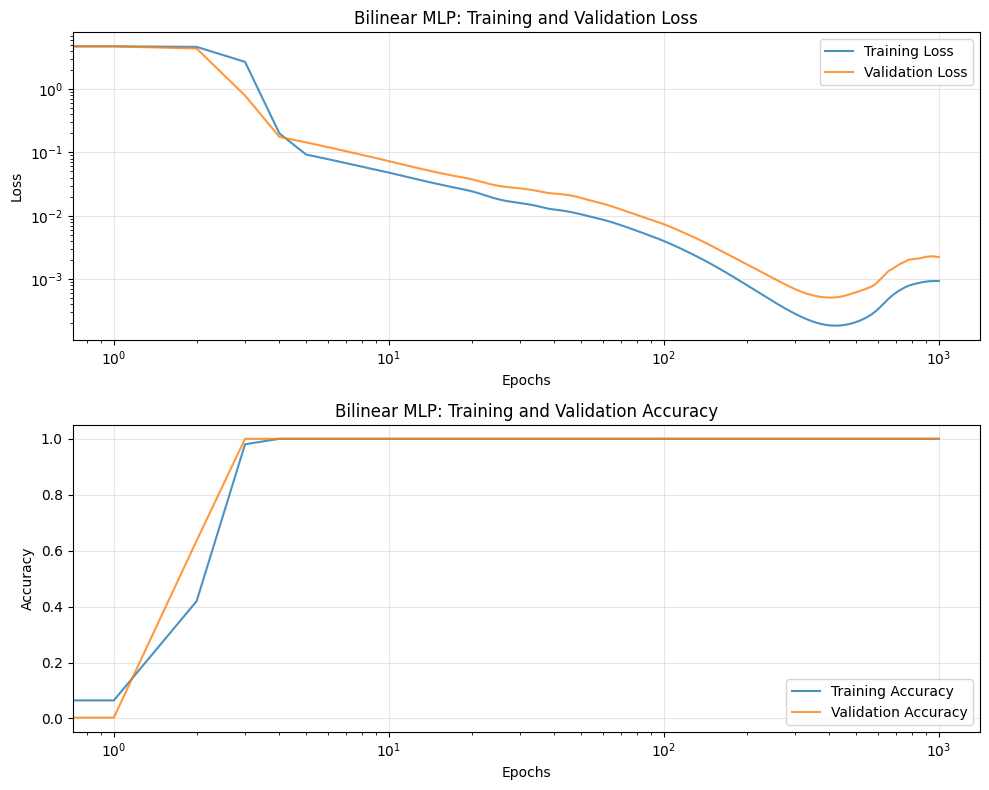

In [15]:
# Plot training curves
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].semilogy(np.arange(num_epochs), train_loss, label='Training Loss', alpha=0.8)
ax[0].semilogy(np.arange(num_epochs), val_loss, label='Validation Loss', alpha=0.8)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Bilinear MLP: Training and Validation Loss')
ax[0].legend(loc='upper right')
ax[0].grid(True, alpha=0.3)
ax[0].set_xscale('log')

ax[1].plot(np.arange(num_epochs), train_acc, label='Training Accuracy', alpha=0.8)
ax[1].plot(np.arange(num_epochs), val_acc, label='Validation Accuracy', alpha=0.8)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Bilinear MLP: Training and Validation Accuracy')
ax[1].legend(loc='lower right')
ax[1].grid(True, alpha=0.3)
ax[1].set_xscale('log')

plt.tight_layout()
plt.show()


## Analyzing Interaction Matrices and Eigenvectors


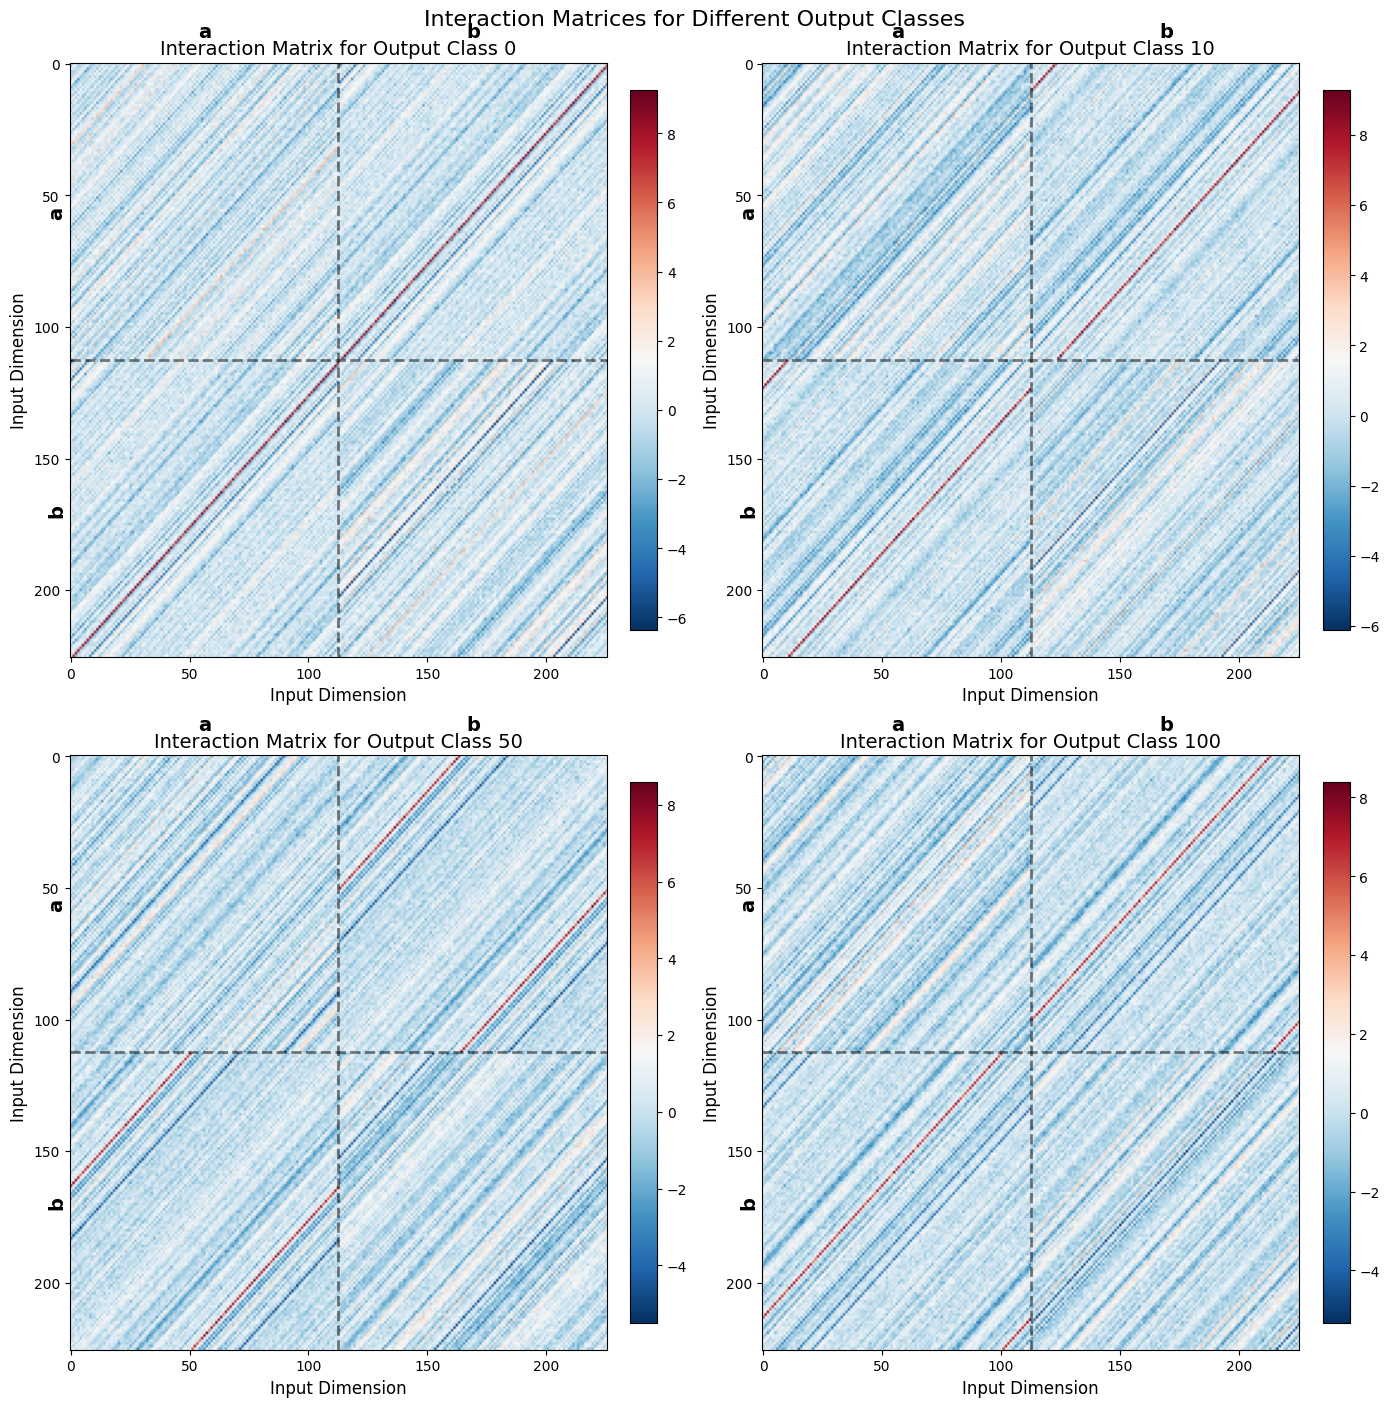

Interaction matrices show how input pairs (a,b) interact to produce each output class.


In [16]:
# Visualize interaction matrices for different output classes
output_classes = [0, 10, 50, 100]

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

bilinear_model.eval()

for idx, output_class in enumerate(output_classes):
    Q = bilinear_model.get_interaction_matrix(output_class)
    Q_np = Q.cpu().detach().numpy()

    im = axes[idx].imshow(Q_np, cmap='RdBu_r', aspect='auto')
    axes[idx].set_title(f'Interaction Matrix for Output Class {output_class}', fontsize=14)
    axes[idx].set_xlabel('Input Dimension', fontsize=12)
    axes[idx].set_ylabel('Input Dimension', fontsize=12)

    axes[idx].axvline(x=p-0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)
    axes[idx].axhline(y=p-0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)

    axes[idx].text(p/2, -10, 'a', ha='center', fontsize=14, fontweight='bold')
    axes[idx].text(p + p/2, -10, 'b', ha='center', fontsize=14, fontweight='bold')
    axes[idx].text(-10, p/2, 'a', va='center', fontsize=14, fontweight='bold', rotation=90)
    axes[idx].text(-10, p + p/2, 'b', va='center', fontsize=14, fontweight='bold', rotation=90)

    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle('Interaction Matrices for Different Output Classes', fontsize=16, y=1.002)
plt.show()

print("Interaction matrices show how input pairs (a,b) interact to produce each output class.")


## Section 3.2

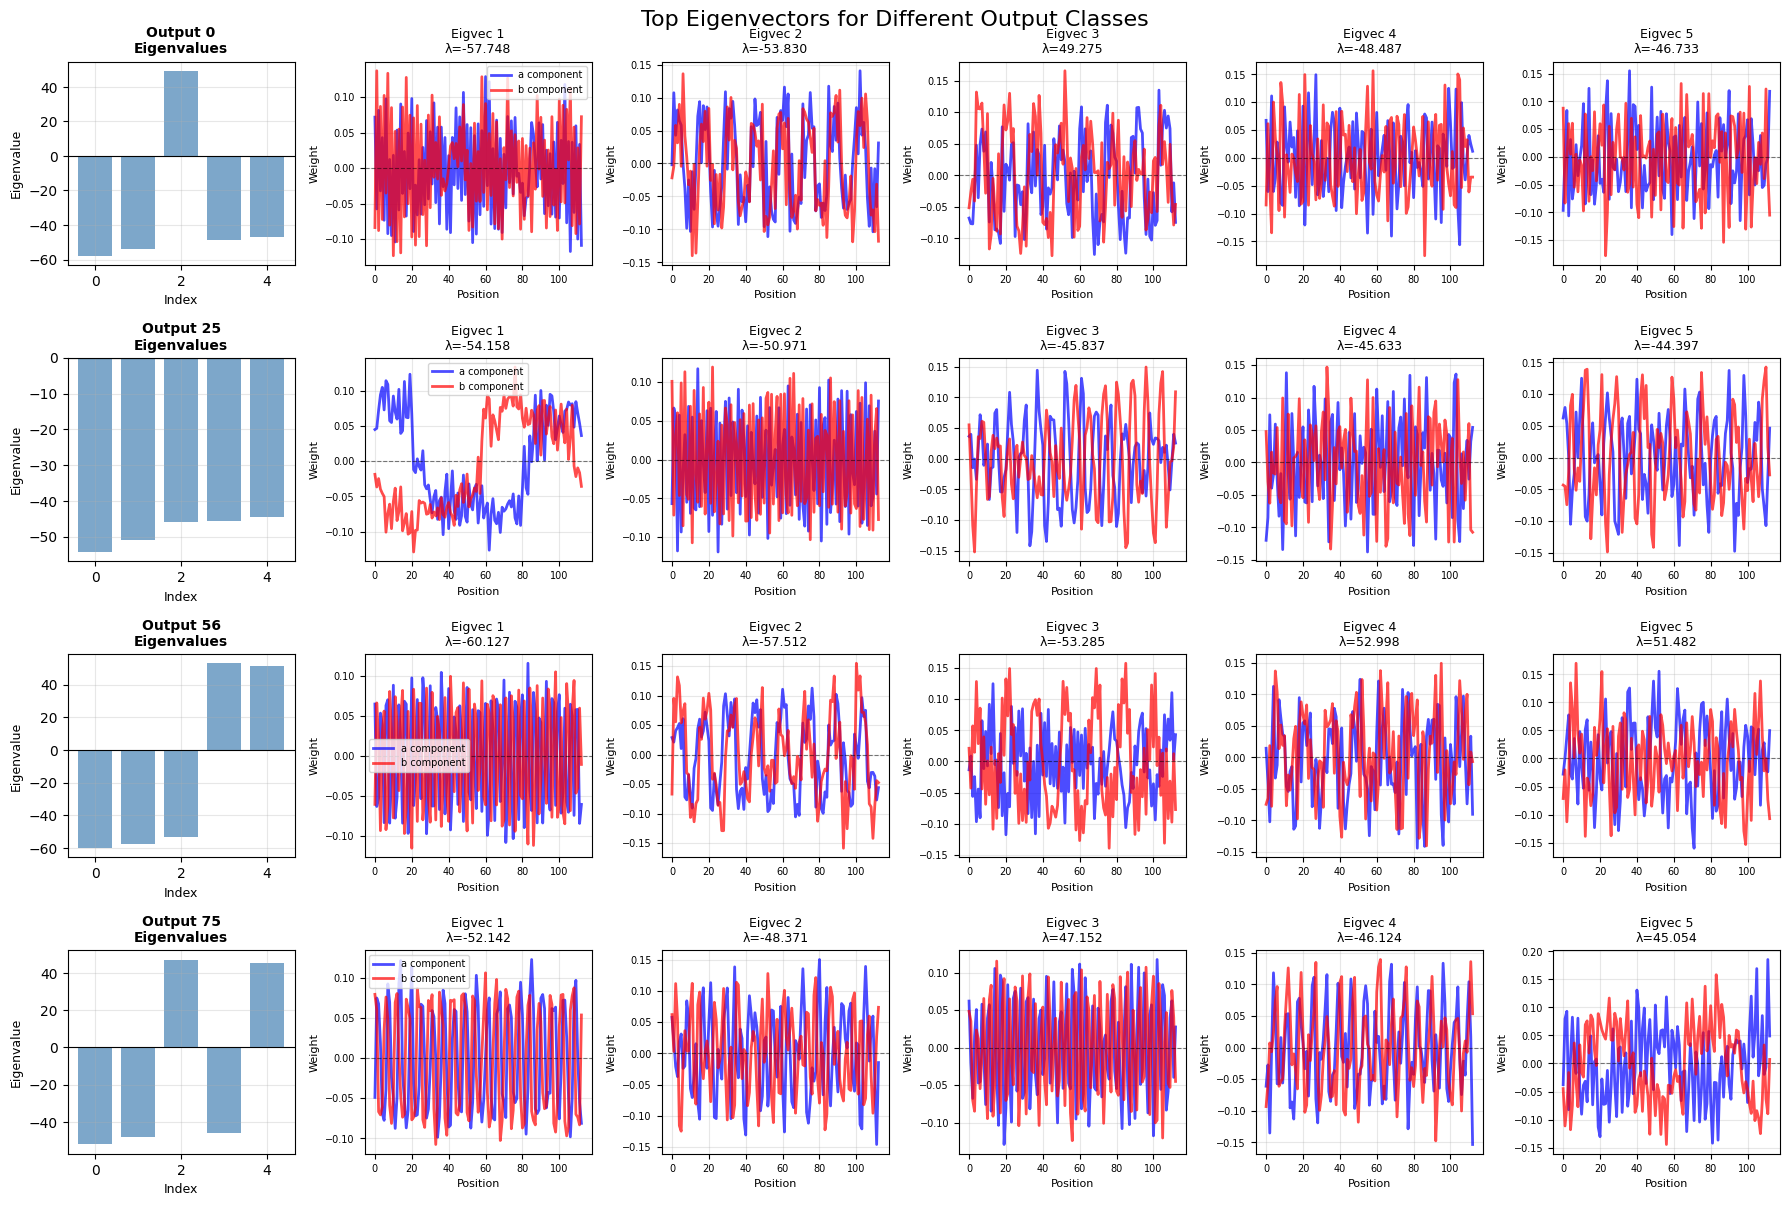

Eigenvectors show the most important input patterns.
The output is quadratic in the eigenvector basis: z^T Q z = Σ λ_i (v_i^T z)^2


In [17]:
# Eigendecomposition: Visualize top eigenvectors for selected output classes
output_classes_eigen = [0, 25, 56, 75]
top_k = 5

fig, axes = plt.subplots(len(output_classes_eigen), top_k + 1, figsize=(18, 12))

for row_idx, output_class in enumerate(output_classes_eigen):
    eigenvalues, eigenvectors = bilinear_model.eigendecompose_output(output_class, top_k=top_k)

    ax = axes[row_idx, 0]
    ax.bar(range(top_k), eigenvalues, color='steelblue', alpha=0.7)
    ax.set_title(f'Output {output_class}\nEigenvalues', fontsize=10, fontweight='bold')
    ax.set_xlabel('Index', fontsize=9)
    ax.set_ylabel('Eigenvalue', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=0.8)

    for i in range(top_k):
        ax = axes[row_idx, i + 1]
        eigvec = eigenvectors[:, i]

        eigvec_a = eigvec[:p]
        eigvec_b = eigvec[p:]

        x = np.arange(p)
        ax.plot(x, eigvec_a, label='a component', color='blue', alpha=0.7, linewidth=2)
        ax.plot(x, eigvec_b, label='b component', color='red', alpha=0.7, linewidth=2)
        ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
        ax.set_title(f'Eigvec {i+1}\nλ={eigenvalues[i]:.3f}', fontsize=9)
        ax.set_xlabel('Position', fontsize=8)
        ax.set_ylabel('Weight', fontsize=8)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend(fontsize=7)
        ax.tick_params(labelsize=7)

plt.tight_layout()
plt.suptitle('Top Eigenvectors for Different Output Classes', fontsize=16, y=1.001)
plt.show()

print("Eigenvectors show the most important input patterns.")
print("The output is quadratic in the eigenvector basis: z^T Q z = Σ λ_i (v_i^T z)^2")


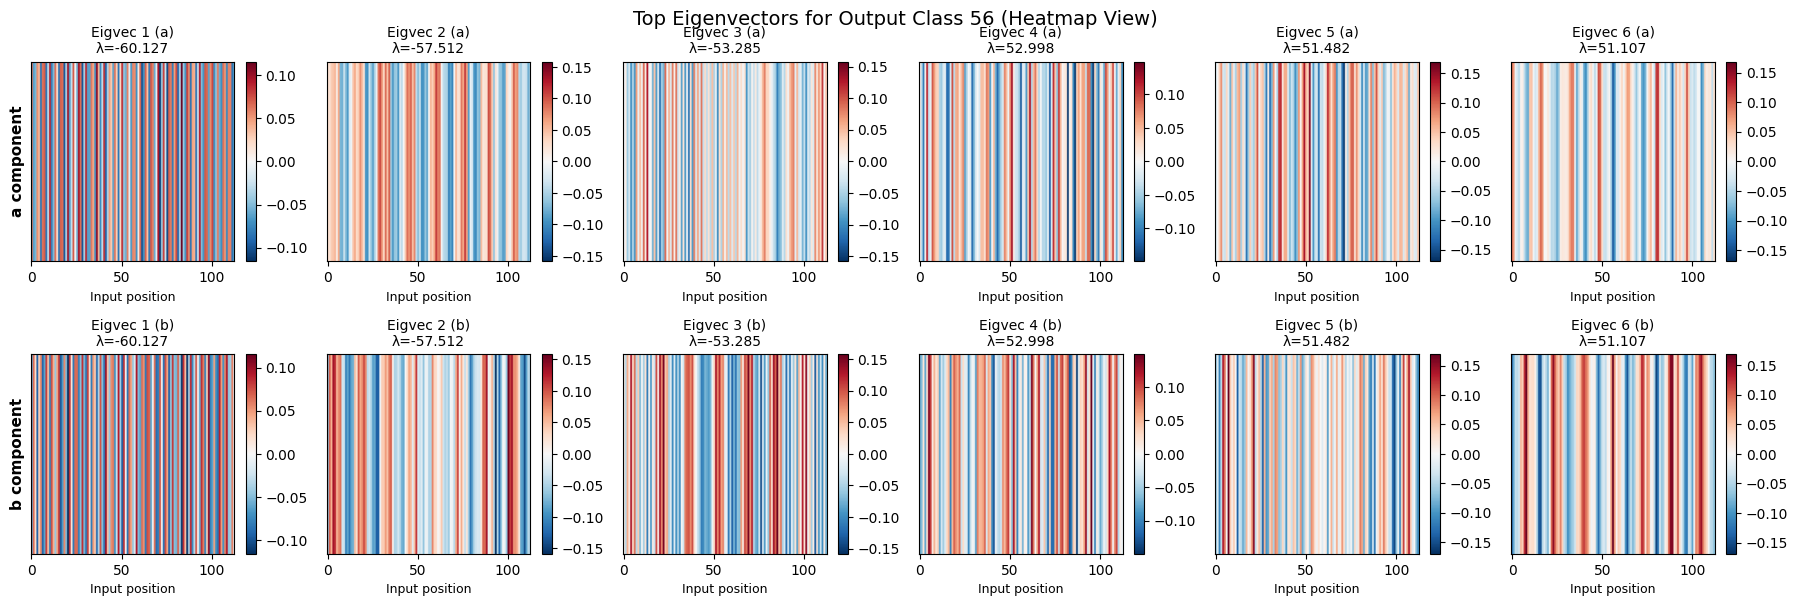


Eigenvalue spectrum for output 56:
Top 6 eigenvalues: [-60.126694 -57.51162  -53.284996  52.99826   51.481937  51.107014]

These eigenvectors capture the periodic patterns in how inputs combine.


In [18]:
# Visualize eigenvectors as heatmaps
focus_output = 56
top_k_viz = 6

eigenvalues, eigenvectors = bilinear_model.eigendecompose_output(focus_output, top_k=top_k_viz)

fig, axes = plt.subplots(2, top_k_viz, figsize=(18, 6))

for i in range(top_k_viz):
    eigvec = eigenvectors[:, i]

    eigvec_a = eigvec[:p].reshape(1, -1)
    eigvec_b = eigvec[p:].reshape(1, -1)

    im1 = axes[0, i].imshow(eigvec_a, cmap='RdBu_r', aspect='auto',
                            vmin=-np.abs(eigvec).max(), vmax=np.abs(eigvec).max())
    axes[0, i].set_title(f'Eigvec {i+1} (a)\nλ={eigenvalues[i]:.3f}', fontsize=10)
    axes[0, i].set_yticks([])
    axes[0, i].set_xlabel('Input position', fontsize=9)
    plt.colorbar(im1, ax=axes[0, i], fraction=0.046)

    im2 = axes[1, i].imshow(eigvec_b, cmap='RdBu_r', aspect='auto',
                            vmin=-np.abs(eigvec).max(), vmax=np.abs(eigvec).max())
    axes[1, i].set_title(f'Eigvec {i+1} (b)\nλ={eigenvalues[i]:.3f}', fontsize=10)
    axes[1, i].set_yticks([])
    axes[1, i].set_xlabel('Input position', fontsize=9)
    plt.colorbar(im2, ax=axes[1, i], fraction=0.046)

axes[0, 0].set_ylabel('a component', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('b component', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.suptitle(f'Top Eigenvectors for Output Class {focus_output} (Heatmap View)',
             fontsize=14, y=1.002)
plt.show()

print(f"\nEigenvalue spectrum for output {focus_output}:")
print(f"Top 6 eigenvalues: {eigenvalues}")
print(f"\nThese eigenvectors capture the periodic patterns in how inputs combine.")


## Analysis Summary and Additional Experiments


BILINEAR MODULAR ADDITION ANALYSIS

Model Architecture:
  - Input size: 226 (one-hot encoded a and b)
  - Hidden size: 100
  - Output size: 113
  - Final validation accuracy: 1.0000

Eigenvalue Analysis:
  - Average effective rank: 50.00
  - Min effective rank: 50
  - Max effective rank: 50

Top eigenvalues statistics (across all outputs):
  - Mean of top eigenvalue: 54.8552
  - Std of top eigenvalue: 5.5393


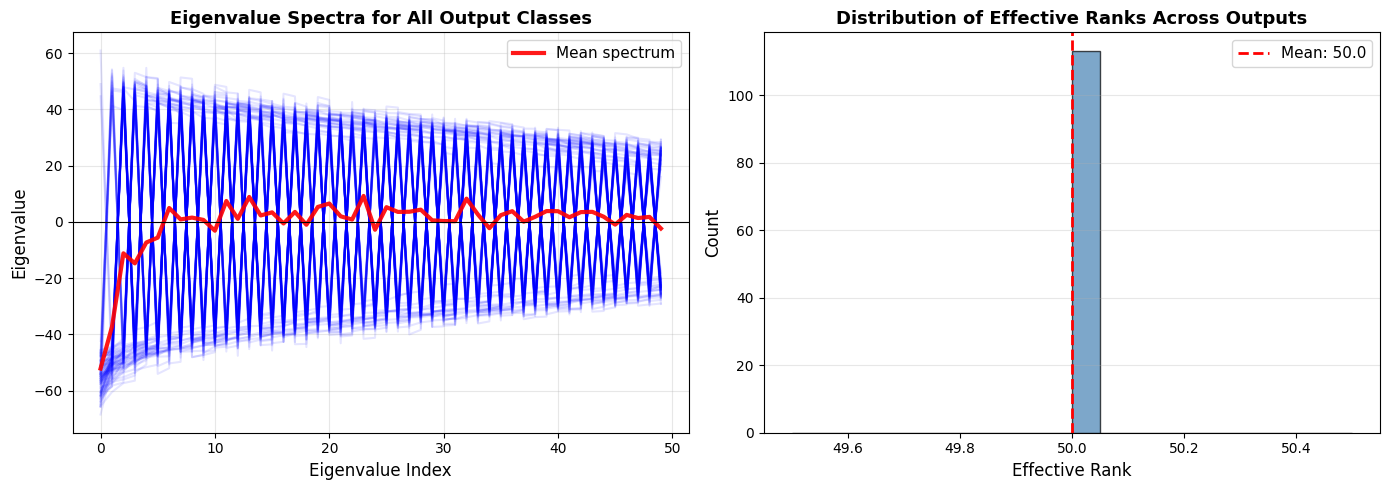

In [25]:
# Analysis: Rank of interaction matrices and eigenvalue distribution

print("=" * 80)
print("BILINEAR MODULAR ADDITION ANALYSIS")
print("=" * 80)

all_eigenvalues = []
effective_ranks = []

for output_class in range(p):
    eigenvalues, _ = bilinear_model.eigendecompose_output(output_class, top_k=50)
    all_eigenvalues.append(eigenvalues)

    threshold = 0.01 * np.abs(eigenvalues[0])
    effective_rank = np.sum(np.abs(eigenvalues) > threshold)
    effective_ranks.append(effective_rank)

all_eigenvalues = np.array(all_eigenvalues)

print(f"\nModel Architecture:")
print(f"  - Input size: {2*p} (one-hot encoded a and b)")
print(f"  - Hidden size: 100")
print(f"  - Output size: {p}")
print(f"  - Final validation accuracy: {val_acc[-1]:.4f}")

print(f"\nEigenvalue Analysis:")
print(f"  - Average effective rank: {np.mean(effective_ranks):.2f}")
print(f"  - Min effective rank: {np.min(effective_ranks)}")
print(f"  - Max effective rank: {np.max(effective_ranks)}")

print(f"\nTop eigenvalues statistics (across all outputs):")
print(f"  - Mean of top eigenvalue: {np.mean(np.abs(all_eigenvalues[:, 0])):.4f}")
print(f"  - Std of top eigenvalue: {np.std(np.abs(all_eigenvalues[:, 0])):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(all_eigenvalues.T, alpha=0.1, color='blue')
axes[0].plot(np.mean(all_eigenvalues, axis=0), color='red', linewidth=3,
             label='Mean spectrum', alpha=0.9)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('Eigenvalue Spectra for All Output Classes', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)
axes[0].axhline(y=0, color='black', linewidth=0.8)

axes[1].hist(effective_ranks, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Effective Rank', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Effective Ranks Across Outputs', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axvline(x=np.mean(effective_ranks), color='red', linewidth=2,
                linestyle='--', label=f'Mean: {np.mean(effective_ranks):.1f}')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


## Section 3.3: Higher-Order SVD (HOSVD)
Discover the most important output directions without prior knowledge of output classes


In [20]:
# Perform HOSVD to discover important output directions
print("Performing Higher-Order SVD (Section 3.3)...")
print("This discovers important output directions without knowing the output classes\n")

num_discovered = 5
U, S, interaction_matrices = bilinear_model.hosvd_decomposition(num_components=num_discovered)

print(f"Top {num_discovered} singular values:")
for i, s in enumerate(S):
    print(f"  Direction {i+1}: {s:.4f}")

# Analyze what each discovered direction emphasizes
print(f"\nOutput class contributions for each discovered direction:")
for i in range(num_discovered):
    # Find which output classes this direction emphasizes most
    top_indices = np.argsort(np.abs(U[:, i]))[-5:][::-1]
    print(f"\nDirection {i+1} (singular value={S[i]:.2f}):")
    print(f"  Top 5 output classes: {top_indices}")
    print(f"  Weights: {U[top_indices, i]}")


Performing Higher-Order SVD (Section 3.3)...
This discovers important output directions without knowing the output classes

Top 5 singular values:
  Direction 1: 704.6178
  Direction 2: 545.1818
  Direction 3: 523.7288
  Direction 4: 519.9420
  Direction 5: 516.1078

Output class contributions for each discovered direction:

Direction 1 (singular value=704.62):
  Top 5 output classes: [12 40 76 46 10]
  Weights: [0.25078866 0.22590572 0.20143537 0.19782911 0.19399211]

Direction 2 (singular value=545.18):
  Top 5 output classes: [95 39 25 34 28]
  Weights: [ 0.32863122 -0.31963465 -0.20600128  0.18597198  0.18111338]

Direction 3 (singular value=523.73):
  Top 5 output classes: [ 6 56 47  1 55]
  Weights: [-0.26206896 -0.2470421   0.21548581  0.20805901 -0.20251781]

Direction 4 (singular value=519.94):
  Top 5 output classes: [47 57 71 87 34]
  Weights: [-0.24703155  0.23384531  0.22871533  0.21045953 -0.20815319]

Direction 5 (singular value=516.11):
  Top 5 output classes: [112 104 

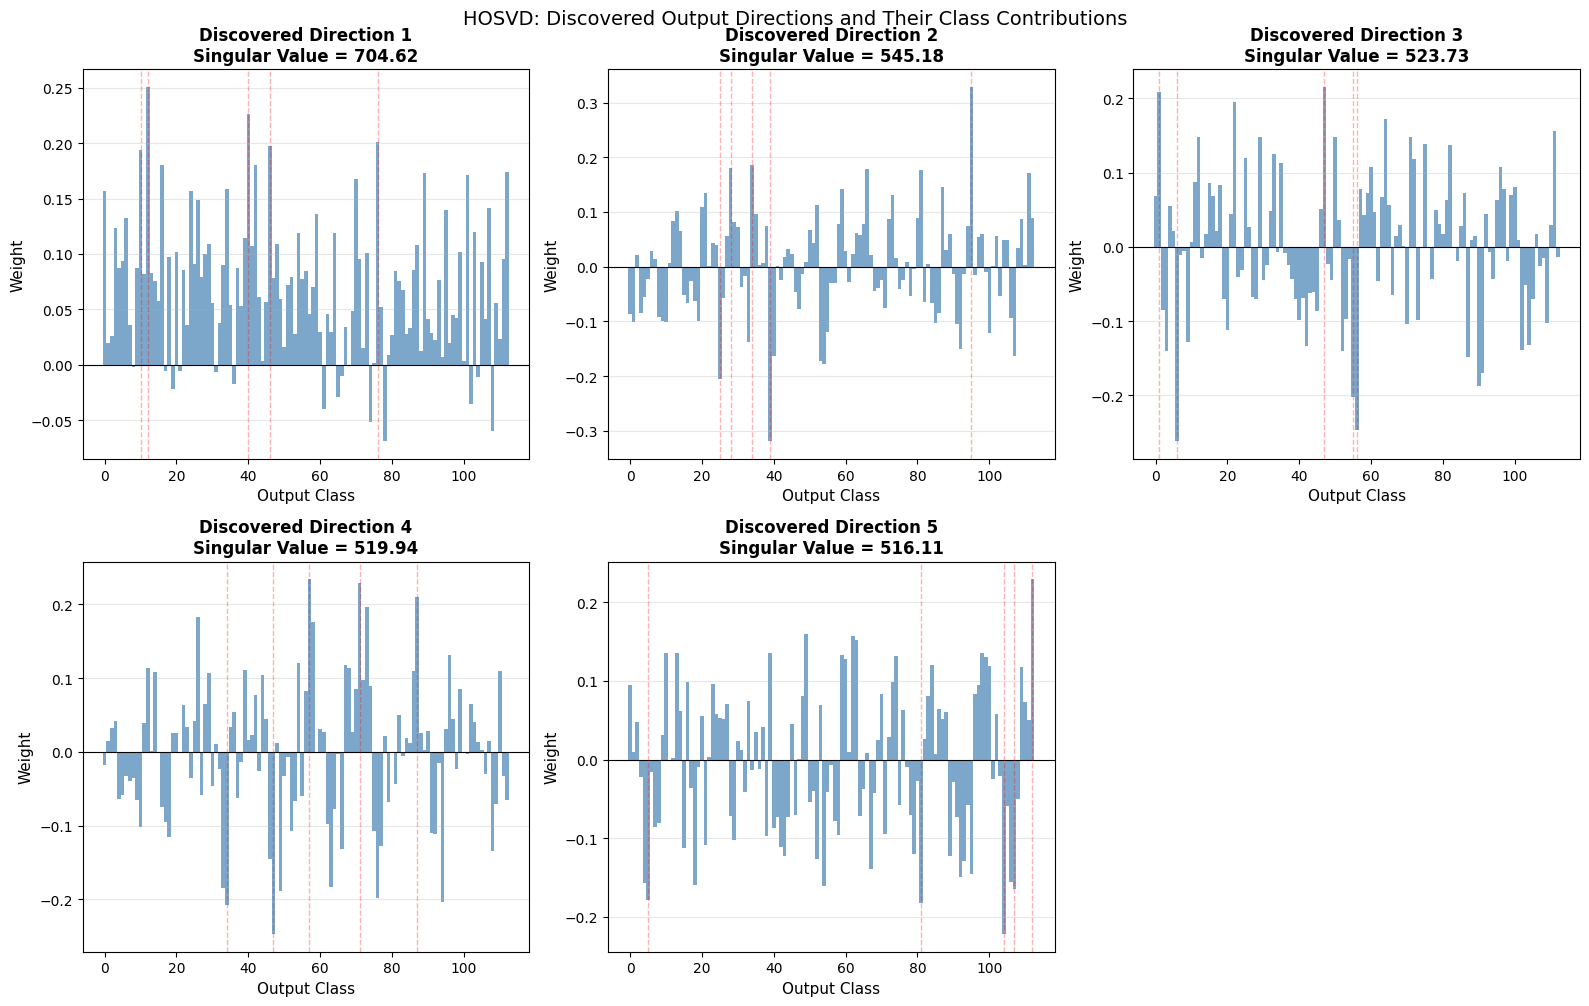


Red dashed lines indicate the top 5 contributing output classes for each direction.


In [21]:
# Visualize output class contributions for discovered directions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i in range(min(num_discovered, 6)):
    ax = axes[i]

    # Plot which output classes contribute to this direction
    ax.bar(range(p), U[:, i], color='steelblue', alpha=0.7, width=1.0)
    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.set_xlabel('Output Class', fontsize=11)
    ax.set_ylabel('Weight', fontsize=11)
    ax.set_title(f'Discovered Direction {i+1}\nSingular Value = {S[i]:.2f}',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Highlight top contributors
    top_5 = np.argsort(np.abs(U[:, i]))[-5:]
    for idx in top_5:
        ax.axvline(x=idx, color='red', alpha=0.3, linewidth=1, linestyle='--')

# Hide unused subplots
for i in range(num_discovered, 6):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('HOSVD: Discovered Output Directions and Their Class Contributions',
             fontsize=14, y=1.002)
plt.show()

print("\nRed dashed lines indicate the top 5 contributing output classes for each direction.")


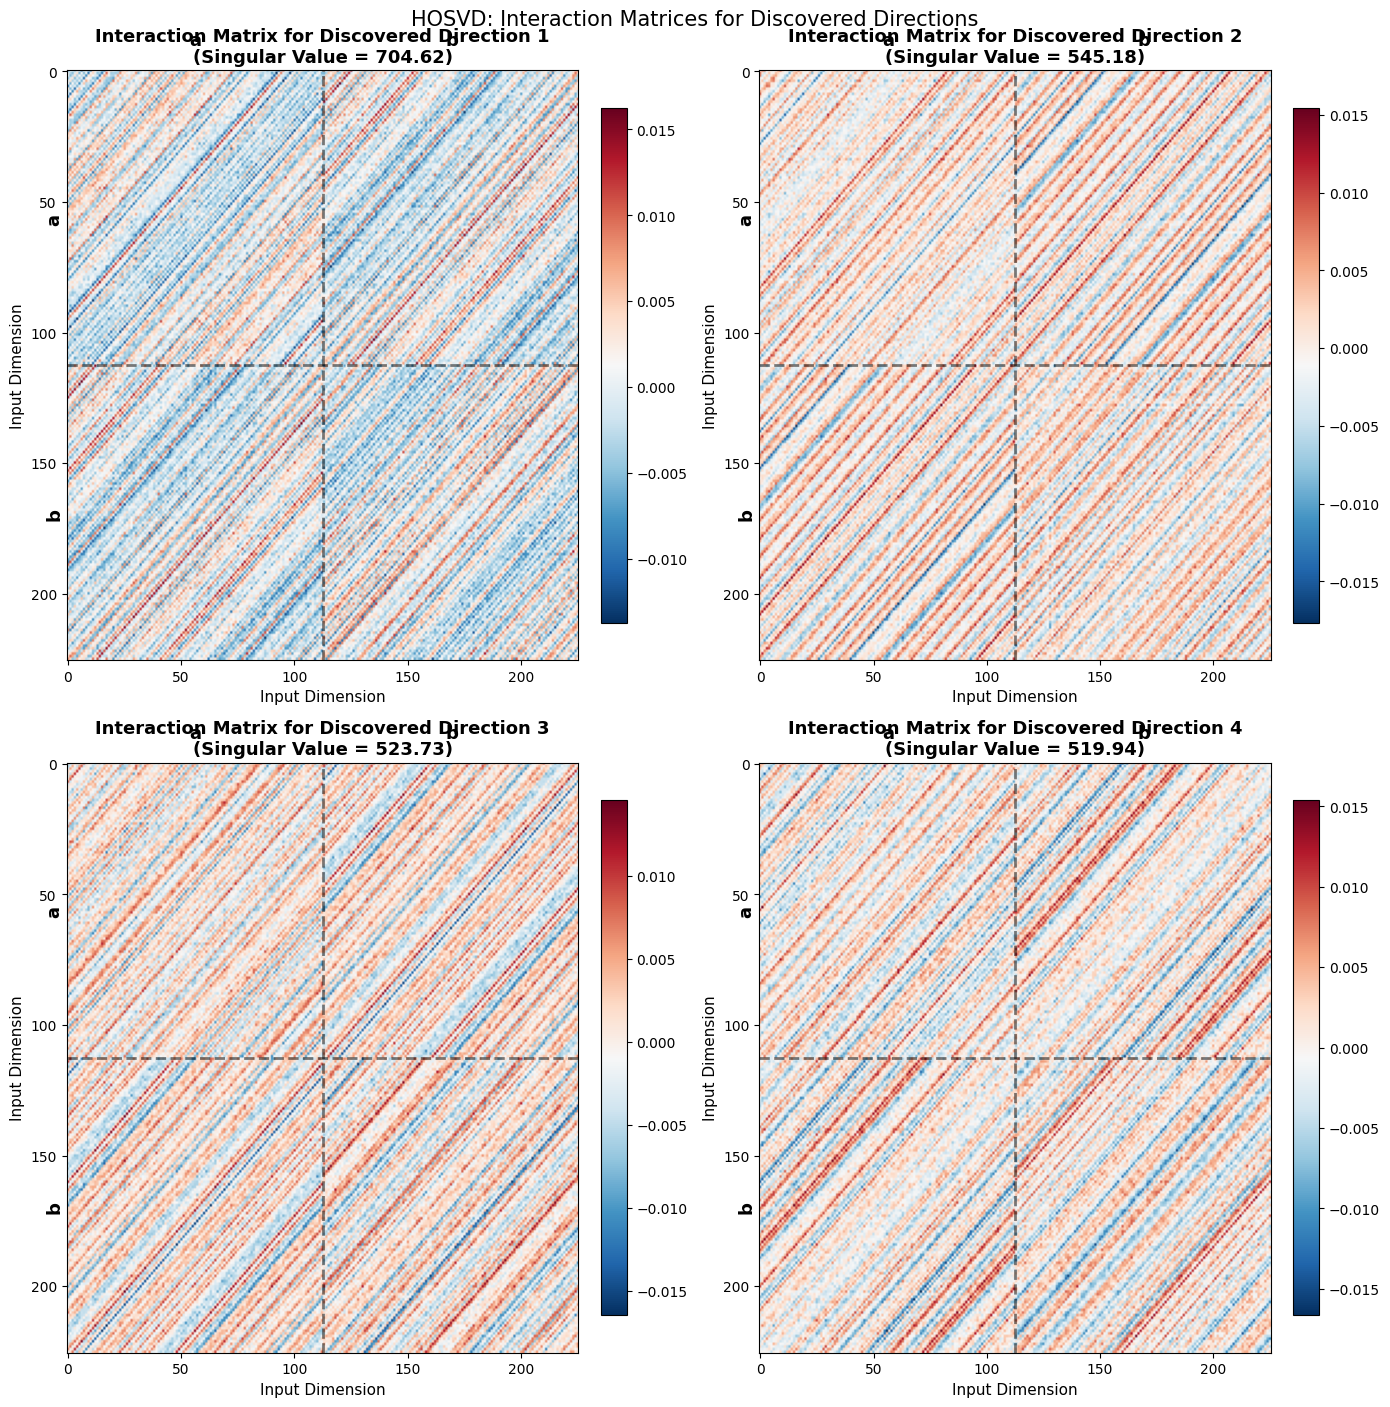

These interaction matrices correspond to 'discovered' output directions,
not specific output classes. They reveal the most important patterns in the weight structure.


In [22]:
# Visualize interaction matrices for discovered directions
num_to_plot = min(4, num_discovered)
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for i in range(num_to_plot):
    Q = interaction_matrices[i]

    im = axes[i].imshow(Q, cmap='RdBu_r', aspect='auto')
    axes[i].set_title(f'Interaction Matrix for Discovered Direction {i+1}\n(Singular Value = {S[i]:.2f})',
                      fontsize=13, fontweight='bold')
    axes[i].set_xlabel('Input Dimension', fontsize=11)
    axes[i].set_ylabel('Input Dimension', fontsize=11)

    # Add separating lines for a and b
    axes[i].axvline(x=p-0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)
    axes[i].axhline(y=p-0.5, color='black', linewidth=2, linestyle='--', alpha=0.5)

    # Add labels
    axes[i].text(p/2, -10, 'a', ha='center', fontsize=13, fontweight='bold')
    axes[i].text(p + p/2, -10, 'b', ha='center', fontsize=13, fontweight='bold')
    axes[i].text(-10, p/2, 'a', va='center', fontsize=13, fontweight='bold', rotation=90)
    axes[i].text(-10, p + p/2, 'b', va='center', fontsize=13, fontweight='bold', rotation=90)

    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle('HOSVD: Interaction Matrices for Discovered Directions', fontsize=15, y=1.002)
plt.show()

print("These interaction matrices correspond to 'discovered' output directions,")
print("not specific output classes. They reveal the most important patterns in the weight structure.")


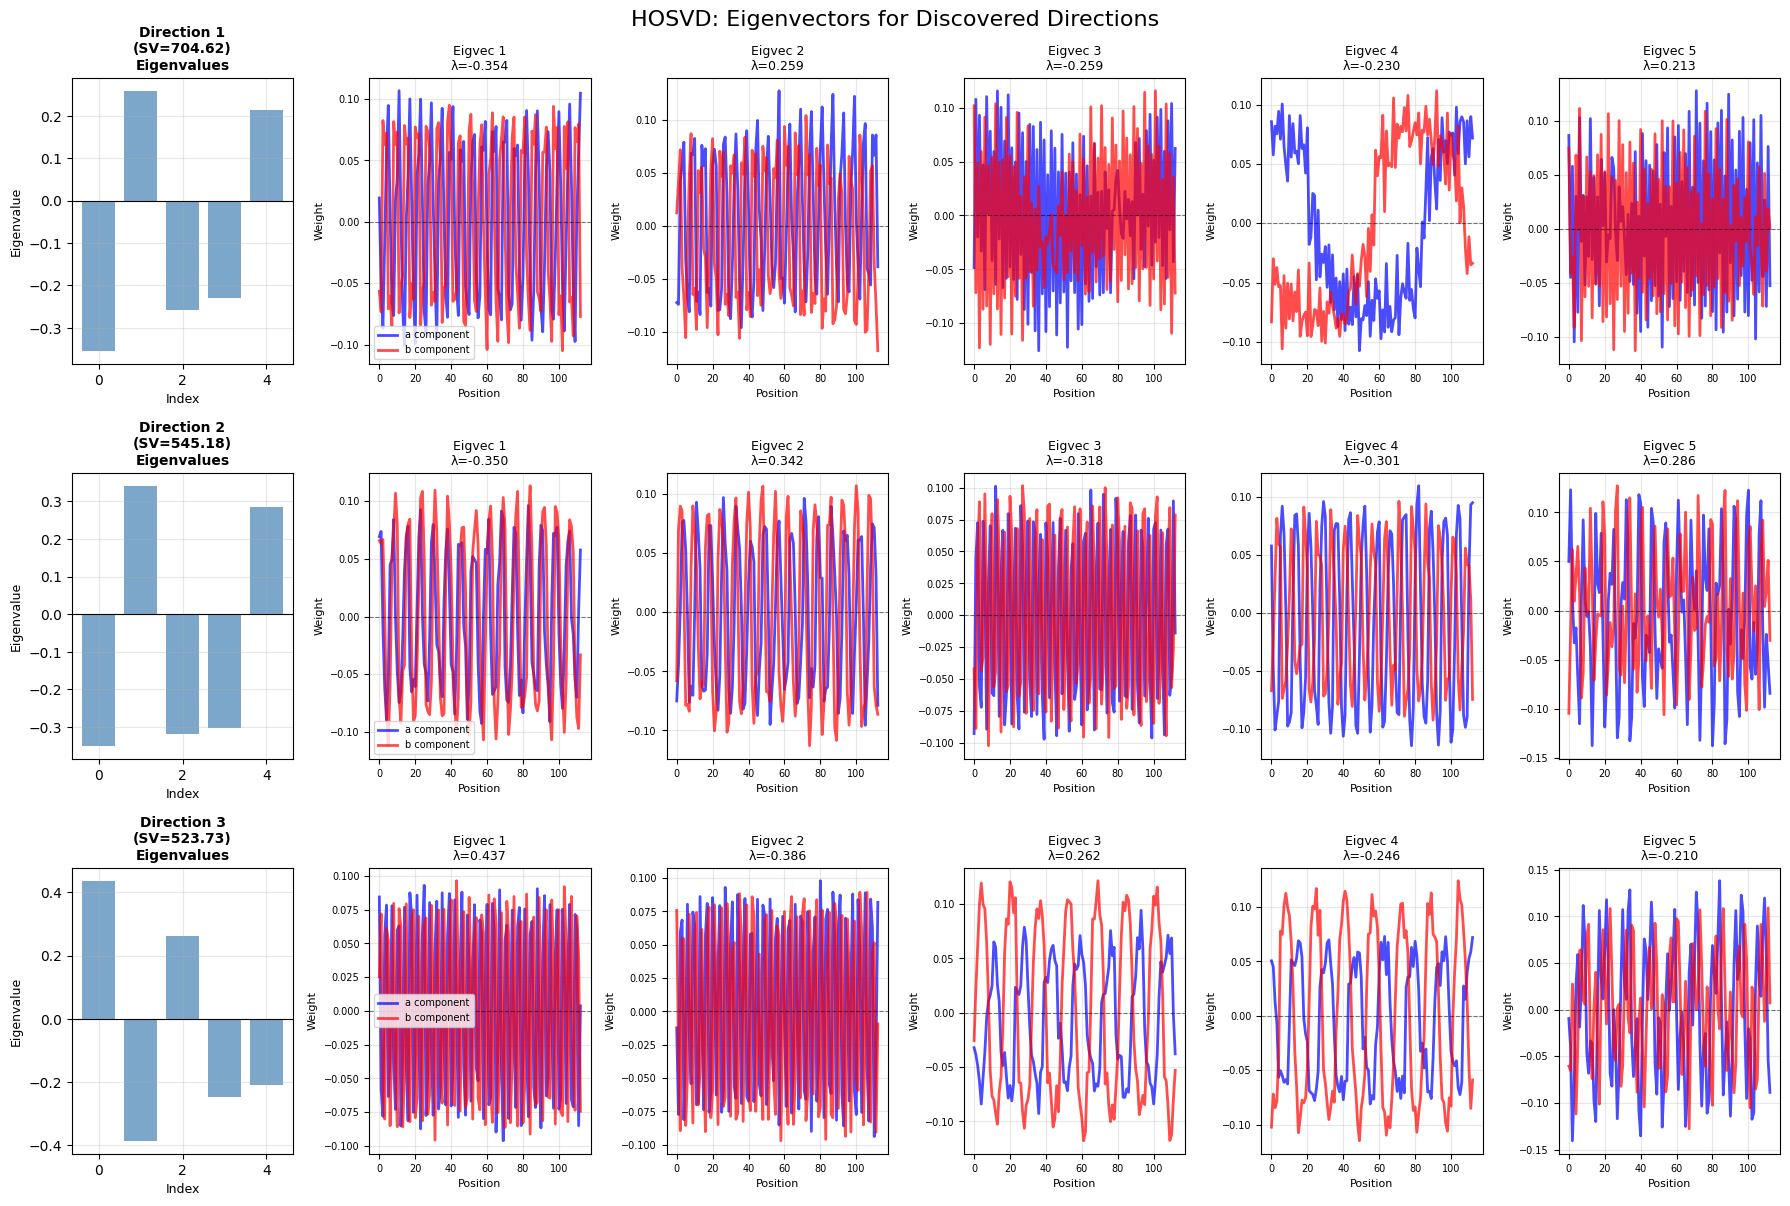


These eigenvectors show the important input patterns for the DISCOVERED directions,
revealing the underlying structure without knowing the output classes in advance.


In [23]:
# Eigendecompose the interaction matrices for discovered directions
num_directions_eigen = min(3, num_discovered)
top_k_hosvd = 5

fig, axes = plt.subplots(num_directions_eigen, top_k_hosvd + 1, figsize=(18, 4*num_directions_eigen))

if num_directions_eigen == 1:
    axes = axes.reshape(1, -1)

for row_idx in range(num_directions_eigen):
    Q = interaction_matrices[row_idx]

    # Eigendecompose this interaction matrix
    eigenvalues, eigenvectors = np.linalg.eigh(Q)
    idx = np.argsort(np.abs(eigenvalues))[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Plot eigenvalue spectrum
    ax = axes[row_idx, 0]
    ax.bar(range(top_k_hosvd), eigenvalues[:top_k_hosvd], color='steelblue', alpha=0.7)
    ax.set_title(f'Direction {row_idx+1}\n(SV={S[row_idx]:.2f})\nEigenvalues',
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Index', fontsize=9)
    ax.set_ylabel('Eigenvalue', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=0.8)

    # Plot top eigenvectors
    for i in range(top_k_hosvd):
        ax = axes[row_idx, i + 1]
        eigvec = eigenvectors[:, i]

        # Split into a and b components
        eigvec_a = eigvec[:p]
        eigvec_b = eigvec[p:]

        x = np.arange(p)
        ax.plot(x, eigvec_a, label='a component', color='blue', alpha=0.7, linewidth=2)
        ax.plot(x, eigvec_b, label='b component', color='red', alpha=0.7, linewidth=2)
        ax.axhline(y=0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
        ax.set_title(f'Eigvec {i+1}\nλ={eigenvalues[i]:.3f}', fontsize=9)
        ax.set_xlabel('Position', fontsize=8)
        ax.set_ylabel('Weight', fontsize=8)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.legend(fontsize=7)
        ax.tick_params(labelsize=7)

plt.tight_layout()
plt.suptitle('HOSVD: Eigenvectors for Discovered Directions', fontsize=16, y=1.001)
plt.show()

print("\nThese eigenvectors show the important input patterns for the DISCOVERED directions,")
print("revealing the underlying structure without knowing the output classes in advance.")
